
# Self-Driving Car Engineer Nanodegree
## Project 4: (Deep Learning) Driving Behavioral Cloning

In this project, I used what I've learned about deep neural networks and convolutional neural networks to clone driving behavior. I trained, validated and tested a model using Keras. The model will output a steering angle to an autonomous vehicle.


In [ ]:
from IPython.display import display_html
display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)

The Keras library is used here because it makes it super easy to arrange the necessary building blocks without spending a lot of time writing boilerplate code.

In [1]:
# Importing useful packages
from utils import load_dataset, plot_data_distribution, plot_training_history
from utils import create_video, reproduce_dataset

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras import optimizers

import matplotlib.pyplot as plt
import numpy as np
import math
import cv2
import os

Using TensorFlow backend.


---
## Step 1: Dataset Loading, Summary and Exploration

Te data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of car's cameras
- `'y_train'` is a 1D array containing the stering value

In [2]:
# Hyper Parameters
CORRECTION = 0.25 # Correction factor for stearing angles
DOWN_LIMIT = 20 # Down Horizontal limits to crop dataset
BATCH_SIZE = 128 # Batch size for training
UP_LIMIT = 65 # Up Horizontal limits to crop dataset
EPOCHS = 20 # NUmber of epochs for traings process

### Dataset Loading and Basic Summay

In [3]:
# Define paths 
dataset_paths = [
    "self-driving-data-capture/track_1(1)",
    "self-driving-data-capture/track_1(2)",
    "self-driving-data-capture/track_2(1)",
    "self-driving-data-capture/track_2(2)"
    ]

# Load dataset
data = load_dataset(dataset_paths,  "driving_log.csv")
data = shuffle(data)

# Separate samples for training and testing process
train_samples, validation_samples = train_test_split(data, test_size=0.2)

From .... riving-data-capture/track_1(1): 6623 samples
From .... riving-data-capture/track_1(2): 6007 samples
From .... riving-data-capture/track_2(1): 9450 samples
From .... riving-data-capture/track_2(2): 7027 samples


Number of Dataset samples: 29107
Number of training samples: 23285
Number of testing samples: 5822


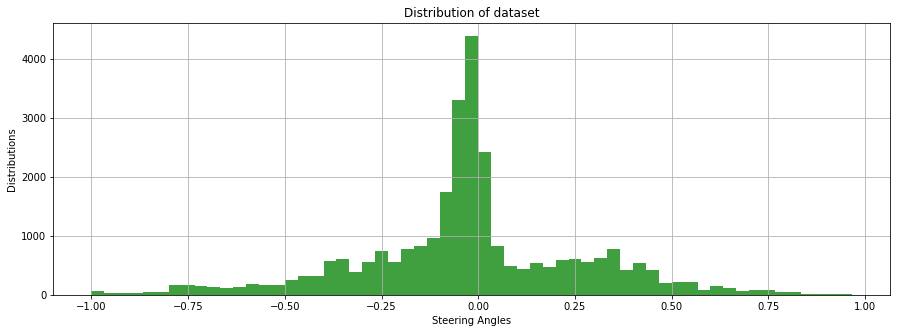

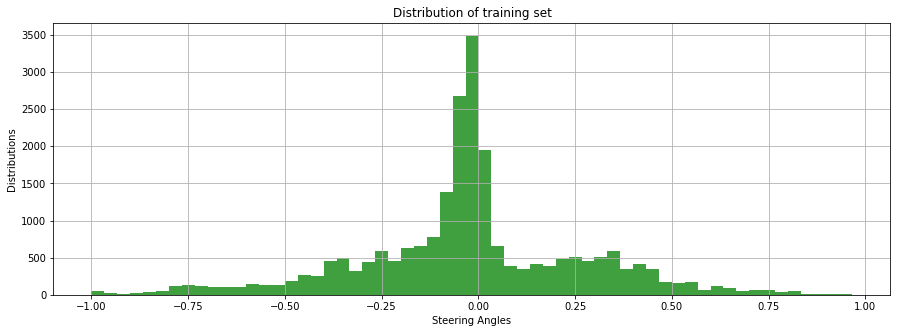

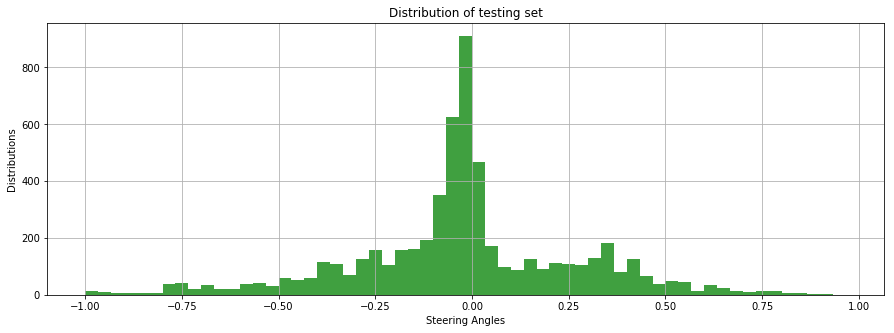

In [4]:
# Print dataset information
print("Number of Dataset samples: {}".format(len(data))) # Number of training examples
print("Number of training samples: {}".format(len(train_samples))) # Number of training examples
print("Number of testing samples: {}".format(len(validation_samples))) # Number of testing examples

# Plot dataset distribution
y_data_raw = np.asarray([data[idx]["steering"] for idx in range(len(data))])
plot_data_distribution(y_data_raw, scfc=30, graph_name="Distribution of dataset", save_name="writeup_files/dataset_stee_angles.png")

# Plot dataset distribution
y_train_raw = np.asarray([train_samples[idx]["steering"] for idx in range(len(train_samples))])
plot_data_distribution(y_train_raw, scfc=30, graph_name="Distribution of training set",  save_name="writeup_files/training_stee_angles.png")

# Plot dataset distribution
y_test_raw = np.asarray([validation_samples[idx]["steering"] for idx in range(len(validation_samples))])
plot_data_distribution(y_test_raw, scfc=30, graph_name="Distribution of testing set",  save_name="writeup_files/testing_stee_angles.png")

In [5]:
def generator(samples, batch_size=32, angle_fc = 0.2):
    
    batch_size_org = batch_size
    batch_size = int(np.ceil(batch_size/6))
    
    while 1: # Loop forever so the generator never terminates
        samples = shuffle(samples)
        
        for offset in range(0, len(samples), batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images = []; angles = []
            
            # Read image and steering angle
            for batch_sample in batch_samples:
                                                    
                # Central camera
                img_c = cv2.cvtColor(cv2.imread(batch_sample["img_c"]), cv2.COLOR_BGR2RGB) 
                ang_c =  batch_sample["steering"]
                
                # Left camera
                img_l = cv2.cvtColor(cv2.imread(batch_sample["img_l"]), cv2.COLOR_BGR2RGB)
                ang_l =  batch_sample["steering"] + angle_fc

                # Right camera
                img_r = cv2.cvtColor(cv2.imread(batch_sample["img_r"]), cv2.COLOR_BGR2RGB)
                ang_r =  batch_sample["steering"] - angle_fc

                # Fliped Left camera
                img_lf = cv2.flip(img_l, 1)
                ang_lf = -ang_l

                # Fliped Right camera
                img_rf = cv2.flip(img_r, 1)
                ang_rf = -ang_r

                # Fliped center camera
                img_cf = cv2.flip(img_c, 1)
                ang_cf = -ang_c 

                images.extend((img_c, img_l, img_r, img_cf, img_lf, img_rf))
                angles.extend((ang_c, ang_l, ang_r, ang_cf, ang_lf, ang_rf))
                      
            images, angles = shuffle(images, angles)
                    
            # trim image to only see section with road
            X_train = np.array(images[:32])
            y_train = np.array(angles[:32])
                        
            # Return batch
            yield shuffle(X_train, y_train)
            

In [6]:
# Create data generators
train_generator = generator(train_samples, BATCH_SIZE, CORRECTION)
validation_generator = generator(validation_samples, BATCH_SIZE, CORRECTION)

### Exploratory Visualization of the Dataset

In [ ]:
# Create videos with current datasets
path_idx = 0
for cam_label in ["img_c", "img_l", "img_r"]:
    create_video(cam_label=cam_label, 
                 dst_path="model/video_results", 
                 src_path=dataset_paths[path_idx],
                 file_name="{}_{}.mp4".format(dataset_paths[path_idx].split("/")[-1], cam_label),
                 video_size=(320, 160),
                 fps=15.
                 )

In [7]:
# Concatenate cameras videos and reproduce  -> A: Stop video - Q: Quit
reproduce_dataset(fps=30, loop=True, sc_fc=1.5, up_limit=UP_LIMIT, down_limit=DOWN_LIMIT, 
                  dataset_path = dataset_paths[2], CORRECTION=CORRECTION)

From .... riving-data-capture/track_2(1): 9450 samples


## Step 2: Designing, Training and Testing a Model Architecture

### Model Training

In [8]:
model = Sequential()

# # Preprocess incoming data, centered around zero with small standard deviation 
model.add(Lambda(lambda x: (x/255.) - 0.5, input_shape=(160, 320, 3)))

# # trim image to only see section with road
model.add(Cropping2D(cropping=((DOWN_LIMIT, UP_LIMIT),(0, 0))))

#layer 1- Convolution, no of filters- 24, filter size= 5x5, stride= 2x2
model.add(Convolution2D(24, 5, 5, subsample=(2,2), activation="relu"))

#layer 2- Convolution, no of filters- 36, filter size= 5x5, stride= 2x2
model.add(Convolution2D(36, 5, 5, subsample=(2,2), activation="relu"))

#layer 3- Convolution, no of filters- 48, filter size= 5x5, stride= 2x2
model.add(Convolution2D(48, 5, 5, subsample=(2,2), activation="relu"))

#layer 4- Convolution, no of filters- 64, filter size= 3x3, stride= 1x1
model.add(Convolution2D(64, 3, 3, activation="relu"))

#layer 5- Convolution, no of filters- 64, filter size= 3x3, stride= 1x1
model.add(Convolution2D(64, 3, 3, activation="relu"))

# model.add(MaxPooling2D())

#flatten image from 2D to side by side
model.add(Flatten())

#layer 6- fully connected layer 1
model.add(Dense(100, activation="relu"))

#Adding a dropout layer to avoid overfitting. Here we are have given the dropout 
# rate as 25% after first fully connected layer
model.add(Dropout(0.25))

#layer 7- fully connected layer 1
model.add(Dense(50, activation="relu"))

#layer 8- fully connected layer 1
model.add(Dense(10, activation="relu"))

#layer 9- fully connected layer 1
#here the final layer will contain one value as this is a regression problem and not classification
model.add(Dense(1))

# the output is the steering angle using mean squared error loss function is the right choice 
# for this regression problem adam optimizer is used here
optimizer = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss="mse", optimizer=optimizer)
history_object  = model.fit_generator(
        train_generator, 
        steps_per_epoch=math.ceil(len(train_samples*6)/BATCH_SIZE), 
        validation_data=validation_generator, 
        validation_steps=math.ceil(len(validation_samples)/BATCH_SIZE), 
        epochs=EPOCHS, 
        verbose=1)

# Save the model whe n finish
model.save('model/behavioral_model.h5')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), strides=(2, 2), activation="relu")`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), strides=(2, 2), activation="relu")`
  del sys.path[0]
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), strides=(2, 2), activation="relu")`
  app.launch_new_instance()
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`


Epoch 1/20
1092/1092 [==============================] - 194s 178ms/step - loss: 0.0652 - val_loss: 0.0435
Epoch 2/20
1092/1092 [==============================] - 76s 69ms/step - loss: 0.0405 - val_loss: 0.0352
Epoch 3/20
1092/1092 [==============================] - 76s 69ms/step - loss: 0.0346 - val_loss: 0.0310
Epoch 4/20
1092/1092 [==============================] - 77s 71ms/step - loss: 0.0314 - val_loss: 0.0264
Epoch 5/20
1092/1092 [==============================] - 98s 89ms/step - loss: 0.0292 - val_loss: 0.0246
Epoch 6/20
1092/1092 [==============================] - 85s 78ms/step - loss: 0.0276 - val_loss: 0.0332
Epoch 7/20
1092/1092 [==============================] - 75s 69ms/step - loss: 0.0271 - val_loss: 0.0255
Epoch 8/20
1092/1092 [==============================] - 74s 68ms/step - loss: 0.0253 - val_loss: 0.0234
Epoch 9/20
1092/1092 [==============================] - 73s 67ms/step - loss: 0.0242 - val_loss: 0.0233
Epoch 10/20
1092/1092 [==============================] - 86s 7

### Plot Testing Results

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 75, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 158, 24)       1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 77, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 37, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 35, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2, 33, 64)         36928     
__________

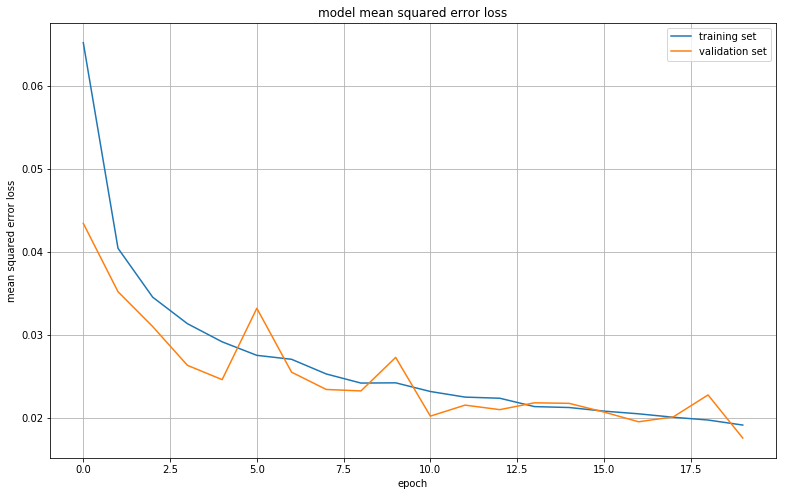

In [9]:
# keras method to print the model summary
model.summary()

# Plot training history
plot_training_history(history_object, fig_size=(13,8), save_name="writeup_files/training_loss_graph.png")

### Run Simulation Enviroment, Model and Other Utils
NOTE: If you recently trained a model you must restart the kernel to free memory

In [ ]:
from IPython.display import display_html
display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)

In [1]:
from utils import setClipboardData, create_model_result_video
from IPython.display import clear_output
from multiprocessing import Pool 
import os

def run_process(process):                                                             
    os.system('{}'.format(process)) 

In [5]:
# Create Video from desktop
video_name = "behavioral_driving_stg{}_test{}.mp4".format(1, 1)
command = "ffmpeg -video_size {}x{} -framerate 25 -f x11grab -i :0.0+100,200 {}".format(
    1000, 650, os.path.join(os.getcwd(), "model/video_results", video_name))
print(command); setClipboardData(command.encode())

ffmpeg -video_size 1000x650 -framerate 25 -f x11grab -i :0.0+100,200 /home/kiwivision/Documents/John_Udacity_Nanodegree_Selfdrivingcars/CarND-P4-Behavioral_Cloning/model/video_results/behavioral_driving_stg1_test1.mp4


In [ ]:
# Create gif from videovideo_name, 
video_name = "stage_1_03312019_img_r"
command = "ffmpeg -i {}.mp4 -ss 15 -t 20 {}.gif -hide_banner".format(video_name, video_name)
print(command); setClipboardData(command.encode())

In [4]:
# Run simulator and socket to drive autonomously
try:
    time_for_server = 10
    processes = (
        "clear && {}".format(os.path.join(os.getcwd(), "beta_simulator_linux", "beta_simulator.x86_64")),
        "clear && termdown {} && clear && python3 {} {} {}".format(
            time_for_server,
            os.path.join(os.getcwd(), "drive.py"), 
            os.path.join(os.getcwd(), "model", "behavioral_model.h5"), 
            os.path.join(os.getcwd(), "model", "image_results ")))
    print(processes[0])
    print(processes[1])
    pool = Pool(processes=len(processes))                                                        
    pool.map(run_process, processes)
except:
    print("Process has finished")

clear && /home/kiwivision/Documents/John_Udacity_Nanodegree_Selfdrivingcars/CarND-P4-Behavioral_Cloning/beta_simulator_linux/beta_simulator.x86_64
clear && termdown 10 && clear && python3 /home/kiwivision/Documents/John_Udacity_Nanodegree_Selfdrivingcars/CarND-P4-Behavioral_Cloning/drive.py /home/kiwivision/Documents/John_Udacity_Nanodegree_Selfdrivingcars/CarND-P4-Behavioral_Cloning/model/behavioral_model.h5 /home/kiwivision/Documents/John_Udacity_Nanodegree_Selfdrivingcars/CarND-P4-Behavioral_Cloning/model/image_results 


In [ ]:
# Run only simulation environment
command = os.path.join(os.getcwd(), "beta_simulator_linux", "beta_simulator.x86_64")
os.system('{}'.format(command)) 
print(command)


In [2]:
# Create model's results video   
create_model_result_video(src_path = os.path.join(os.getcwd(), "model", "image_results"), 
                          dst_path = os.path.join(os.getcwd(), "model", "video_results"),
                          video_size = (360, 160))